# MS Topo Layer API Query

In [61]:
import os
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import rasterio
from rasterio.plot import show 
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from osdatahub import NGD
from osdatahub import Extent
from dotenv import load_dotenv
from shapely.geometry import Polygon

#### Setting up the API
Location data is fetched from OS Data Hub APIs. This analysis uses Premium data from the OS Features API, so you will need a Premium account.

In [62]:
# Set API key, details from https://github.com/OrdnanceSurvey/osdatahub
load_dotenv()
key_os = os.environ['KEY']

In [63]:
ngd_collections = NGD.get_collections()
for collection in ngd_collections['collections']:
    print(f' - {collection["title"]} ({collection["id"]})')

 - Building v1 (bld-fts-building-1)
 - Building Line v1 (bld-fts-buildingline-1)
 - Building Part v1 (bld-fts-buildingpart-1)
 - Named Area v1 (gnm-fts-namedarea-1)
 - Named Point v1 (gnm-fts-namedpoint-1)
 - Land v1 (lnd-fts-land-1)
 - Landform v1 (lnd-fts-landform-1)
 - Landform Line v1 (lnd-fts-landformline-1)
 - Landform Point v1 (lnd-fts-landformpoint-1)
 - Land Point v1 (lnd-fts-landpoint-1)
 - Site v1 (lus-fts-site-1)
 - Site Access Location v1 (lus-fts-siteaccesslocation-1)
 - Site Routing Point v1 (lus-fts-siteroutingpoint-1)
 - Compound Structure v1 (str-fts-compoundstructure-1)
 - Structure v1 (str-fts-structure-1)
 - Structure Line v1 (str-fts-structureline-1)
 - Structure Point v1 (str-fts-structurepoint-1)
 - Cartographic Rail Detail v1 (trn-fts-cartographicraildetail-1)
 - Rail v1 (trn-fts-rail-1)
 - Road Line v1 (trn-fts-roadline-1)
 - Road Track Or Path v1 (trn-fts-roadtrackorpath-1)
 - Connecting Link v1 (trn-ntwk-connectinglink-1)
 - Connecting Node v1 (trn-ntwk-conn

### Select site area

In [64]:
# load the NCA for the PDNP https://naturalengland-defra.opendata.arcgis.com/datasets/national-character-areas-england
nca = "../content/nca_areas/National_Character_Areas___Natural_England.shp"
nca = gpd.read_file(nca)

<AxesSubplot:>

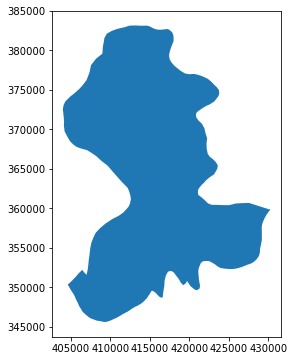

In [65]:
# select the white peak
wp = nca[nca.NCA_Name=="White Peak"]
wp.plot(figsize=(6,6))

In [66]:
# load pdnp boundary https://naturalengland-defra.opendata.arcgis.com/datasets/national-parks-england/explore
np = "../content/pdnp_boundary/National_Parks_(England)___Natural_England.shp"
np = gpd.read_file(np)
pdnp = np[np.NAME=="PEAK DISTRICT"]

<AxesSubplot:>

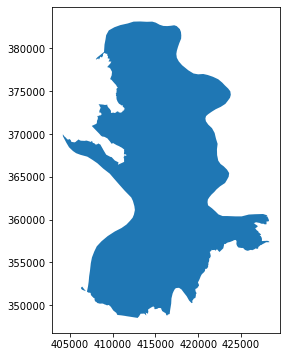

In [67]:
# Cut WP to PDNP boundary
pdnp_wp = gpd.clip(wp,pdnp)
pdnp_wp.plot(figsize=(6,6))

Small area at bottom of the wp nca that doen's quite extend the pdnp boundary. Maybe needs adding back in will give it some thought. Won't matter with intersection of 1km Grid but probably would with a patch intersection. 

#### Grid Selctor

In [68]:
# load pdnp boundary 
lcg = "../content/landscape_character_grid/Landscape_Character_Grid.shp"
lcg = gpd.read_file(lcg)

<AxesSubplot:>

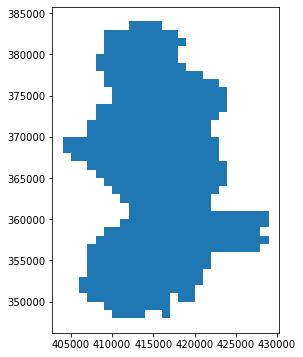

In [69]:
# Select grid by intersection
lcg_wp = gpd.sjoin(lcg, pdnp_wp)
lcg_wp.plot(figsize=(6,6))

In [70]:
# save as a new file 
out_file_path = r"../content/landscape_character_grid/selection_white_peak.shp"
lcg_wp.to_file(out_file_path)

# Get a list of tiles for the project
tile_num = lcg_wp['PLAN_NO']
print(len(tile_num))

C:\Users\alexad\AppData\Local\Temp\ipykernel_2464\462301703.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lcg_wp.to_file(out_file_path)


500


#### Create Sample area

In [71]:
# A3_80 = Walls 5 highest area of lost between 1970 & 1980 coco & chosen area near Sheldon 
sheldon = ['SK1768', 'SK1868', 'SK1767', 'SK1867']
site = lcg_wp.loc[(lcg_wp['PLAN_NO'].isin(sheldon)) | (lcg_wp['A3_80'] > 25)] 
site

,PLAN_NO,MAPNUM,SQNUM,B1_70,B2_70,B3_70,B6_70,B1_80,B2_80,B3_80,...,index_right,JCACODE,JCANAME,NCA_Name,NAID,NANAME,Area_SqKM,Hotlink,ALT,BLT
1050,SK1070,50,1,0,0,1,0,0,0,1,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1274,SK1474,50,25,0,0,1,0,0,0,0,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1276,SK1476,41,10,0,0,0,4,0,0,0,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1325,SK1570,51,1,0,0,2,15,0,0,2,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1388,SK1678,42,17,0,0,0,7,0,0,0,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1432,SK1767,60,13,0,0,0,2,0,0,0,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1433,SK1768,60,18,0,0,2,6,0,0,2,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1487,SK1867,60,14,0,0,1,3,0,0,1,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1488,SK1868,60,19,0,0,1,1,0,0,1,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland


<AxesSubplot:>

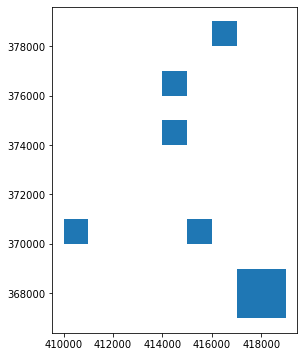

In [72]:
# take look
site.plot(figsize=(6,6))

In [73]:
# save as a new file 
out_file_path = r"../content/landscape_character_grid/site_area.shp"
site.to_file(out_file_path)

# get bounds of each object 
bounds = round(site.bounds)

C:\Users\alexad\AppData\Local\Temp\ipykernel_2464\1452702903.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  site.to_file(out_file_path)


#### 2nd sample area

In [74]:
hd_rake = ['SK1668','SK1567','SK1668','SK1468','SK1469']
site_b = lcg_wp.loc[(lcg_wp['PLAN_NO'].isin(hd_rake))] 
site_b

,PLAN_NO,MAPNUM,SQNUM,B1_70,B2_70,B3_70,B6_70,B1_80,B2_80,B3_80,...,index_right,JCACODE,JCANAME,NCA_Name,NAID,NANAME,Area_SqKM,Hotlink,ALT,BLT
1268,SK1468,59,20,0,0,3,0,0,0,3,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1269,SK1469,59,25,0,0,4,0,0,0,4,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1322,SK1567,60,11,0,0,0,5,0,0,0,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland
1378,SK1668,60,17,0,0,0,6,0,0,0,...,51,52.0,White Peak,White Peak,30.0,White Peak,529,http://www.naturalengland.org.uk/publications/...,Upland,Upland


<AxesSubplot:>

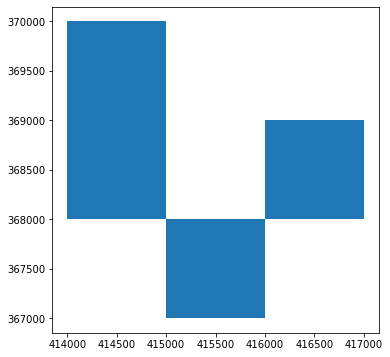

In [75]:
# take a look
site_b.plot(figsize=(6,6))

In [76]:
# save as a new file 
out_file_path = r"../content/landscape_character_grid/site_area_b.shp"
site_b.to_file(out_file_path)

# get bounds of each object 
bounds = round(site_b.bounds)

C:\Users\alexad\AppData\Local\Temp\ipykernel_2464\1278052430.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  site_b.to_file(out_file_path)


#### Fetching Data (for site_b currently)

In [77]:
bounds.rename(columns={"minx": "west", "miny": "south", "maxx": "east", "maxy": "north", })
bounds

,minx,miny,maxx,maxy
1268,414000.0,368000.0,415000.0,369000.0
1269,414000.0,369000.0,415000.0,370000.0
1322,415000.0,367000.0,416000.0,368000.0
1378,416000.0,368000.0,417000.0,369000.0


In [78]:
#### should really automate this in to the API query ####

# Using the same coordinates as the previous example
west, south = (bounds['minx'].values[3]), (bounds['miny'].values[3])
east, north = (bounds['maxx'].values[3]), (bounds['maxy'].values[3])
bbox_extent = Extent.from_bbox((west, south, east, north), crs="EPSG:27700")
bbox_extent
north

369000.0

In [79]:
# API variables
collection = "str-fts-structureline-1"
str_ngd = NGD(key_os, collection)

# call features from API 
str_features = str_ngd.query(extent=bbox_extent, crs="EPSG:27700", max_results=10000000)

In [80]:
type(str_features)

dict

#### Process the data 

In [81]:
# create gpd df
str_gdf = gpd.GeoDataFrame.from_features(str_features, crs="EPSG:27700")
#subset based on 'Built Obstruction' can't figure out a way to filter the API yet
groups = str_gdf['description'].unique()
print(groups)

['Built Obstruction' 'Gate or Barrier']


In [82]:
# filter
str_gdf = str_gdf[str_gdf['description'] == 'Built Obstruction']
str_gdf.head(2)

,geometry,osid,toid,theme,istidal,changetype,ishistoric,isobscured,description,versiondate,...,operationalstatus,description_source,geometry_updatedate,capturespecification,geometry_evidencedate,description_updatedate,versionavailabletodate,firstdigitalcapturedate,description_evidencedate,versionavailablefromdate
0,"LINESTRING (416922.000 368079.040, 416920.970 ...",00107f0e-ec29-4e2b-9e37-fafec0fe111c,osgb1000000108301544,Structures,False,New,False,False,Built Obstruction,2022-08-26,...,Unknown,Ordnance Survey,2005-10-04,Rural,2005-10-04,2005-10-04,None,1999-12-11,2005-10-04,2022-08-27T00:00:00Z
1,"LINESTRING (417111.850 368861.310, 417100.917 ...",01433aaa-366a-4f7c-a563-411853c8603a,osgb5000005226543138,Structures,False,New,False,False,Built Obstruction,2022-08-26,...,Unknown,Ordnance Survey,2020-12-15,Rural,2020-05-29,2018-03-07,None,2018-04-03,2017-04-09,2022-08-27T00:00:00Z


(Text(0.5, 69.0, 'Eastings'), Text(164.32825517966543, 0.5, 'Northings'))

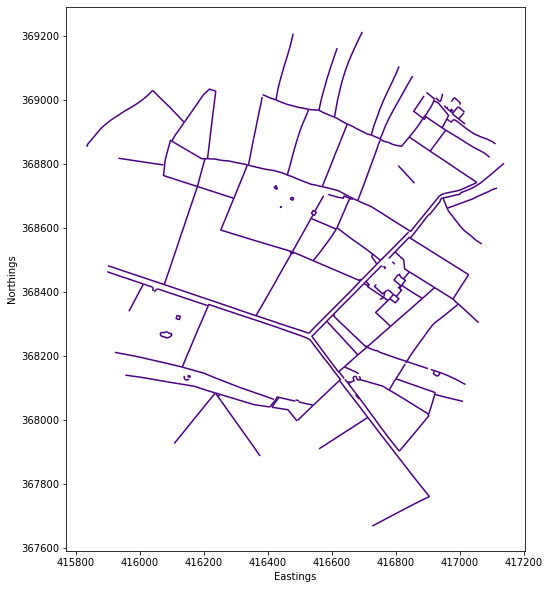

In [83]:
ax = str_gdf.plot(color="indigo", figsize=(12, 10))
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")

In [84]:
# save as a new file 
out_file_path = r"../content/ngd_boundaries/structureline_wp_1568.shp"
str_gdf.to_file(out_file_path)

C:\Users\alexad\AppData\Local\Temp\ipykernel_2464\1970206769.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  str_gdf.to_file(out_file_path)


##### Create layer for overriding Urban Area 

In [85]:
# based on cnn-land-cover/notebooks/Create manual layer to override model predictions.ipynb (@vdplasthijs)
# apart from roads as many walls feature at the side of roads in the WP

collections = {'buildings' : 'bld-fts-buildingpart-1',
               'sites' : 'lus-fts-site-1', 
               'railways' : 'trn-fts-rail-1', 
               'water' : 'wtr-fts-waterpoint-1', 
               'land' : 'lnd-fts-land-1'}

dict_os_layers = {}

for key, value in collections.items():
    ngd = NGD(key_os, value)
    ngd_ = "ngd_" + key
    dict_os_layers[ngd_] = ngd.query(extent=bbox_extent, crs="EPSG:27700", max_results=100000000)
    # convert to gpd  
    if dict_os_layers[ngd_]['numberReturned'] > 0:
        # create gpd globally
        globals()[ngd_] = gpd.GeoDataFrame.from_features(dict_os_layers[ngd_], crs="EPSG:27700")
        print(ngd_ + " geo df created, containg the following number of features:")
        print(dict_os_layers[ngd_]['numberReturned'])
    else:
        print(key + " Dictionary is empty!")
    

ngd_buildings geo df created, containg the following number of features:
24
ngd_sites geo df created, containg the following number of features:
6
railways Dictionary is empty!
water Dictionary is empty!
ngd_land geo df created, containg the following number of features:
142


In [86]:
# Select land 
groups_land = ngd_land['description'].unique()
groups_land

array(['Made Surface', 'Arable Or Grazing Land', 'Bare Earth Or Grass',
       'Heath Or Rough Grassland', 'Residential Garden',
       'Non-Coniferous Trees', 'Mixed Trees'], dtype=object)

In [87]:
# filter
ngd_land = (ngd_land.loc[(ngd_land['description']== 'Made Surface') | (ngd_land['description']== 'Residential Garden')])
len(ngd_land)

18

In [88]:
type(ngd_land)

geopandas.geodataframe.GeoDataFrame

### Create a final Mask for annotation

In [89]:
mask = pd.concat([ngd_land, ngd_buildings, ngd_sites])
len(mask)

48

In [90]:
type(mask)

geopandas.geodataframe.GeoDataFrame

In [49]:
mask.columns

Index(['geometry', 'osid', 'toid', 'theme', 'istidal', 'landform',
       'changetype', 'isobscured', 'description', 'versiondate',
       'geometry_area', 'physicallevel', 'oslandusetiera', 'oslandusetierb',
       'geometry_source', 'oslandcovertiera', 'oslandcovertierb',
       'oslanduse_source', 'operationalstatus', 'description_source',
       'oslandcover_source', 'associatedstructure', 'geometry_updatedate',
       'capturespecification', 'oslanduse_updatedate', 'geometry_evidencedate',
       'description_updatedate', 'oslandcover_updatedate',
       'oslanduse_evidencedate', 'versionavailabletodate',
       'firstdigitalcapturedate', 'description_evidencedate',
       'oslandcover_evidencedate', 'versionavailablefromdate', 'height_source',
       'height_updatedate', 'height_evidencedate', 'absoluteheightmaximum',
       'absoluteheightminimum', 'heightconfidencelevel',
       'relativeheightmaximum', 'absoluteheightroofbase',
       'relativeheightroofbase', 'name1_text', 'n

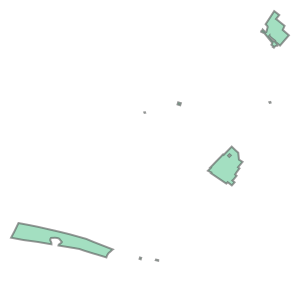

In [50]:
mask.unary_union

In [51]:
type(mask)

geopandas.geodataframe.GeoDataFrame

In [52]:
# dissolve polygons
mask['pdnp'] = 'pdnp'
mask = mask.dissolve(by = 'pdnp', as_index=False)

In [54]:
# add a buffer
mask = mask.buffer(10)

In [55]:
# load tiff
src = rasterio.open("../content/tifs/189226695.27.tif")

(367000.0, 369000.0)

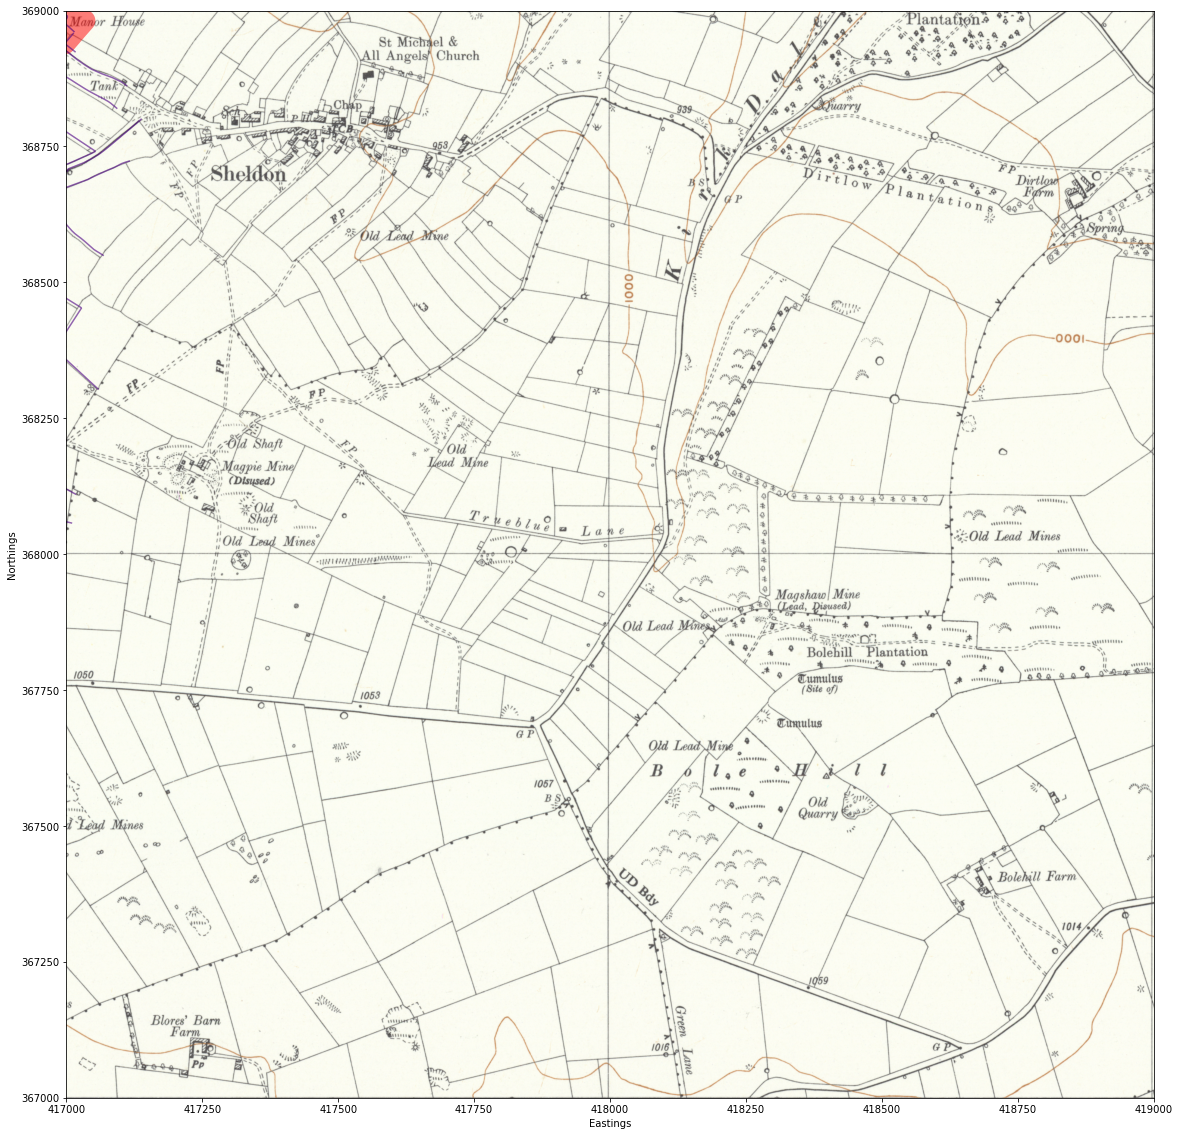

In [56]:
ax = str_gdf.plot(color="indigo", alpha=0.6, figsize=(20, 20))
mask.plot(ax=ax, color="red",  alpha=0.5)
show(src, ax=ax, with_bounds=True)
ax.set_xlabel("Eastings"), ax.set_ylabel("Northings")
ax.set_xlim(417000, xmax=419000)
ax.set_ylim(367000, ymax=369000)

In [57]:
# save as a new file 
out_file_path = r"../content/ngd_boundaries/mask_wp_1568.shp"
mask.to_file(out_file_path)